In [1]:
import sys
sys.path.append("../python/")

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import bokeh.palettes
import _corner
import imp
imp.reload(_corner)
from _corner import corner
from scipy.stats import gaussian_kde
import pickle
from matplotlib.offsetbox import AnchoredText
import mock_generation
imp.reload(mock_generation)
from mock_generation import mock_population
from astropy.constants import R_jup, M_jup, M_sun, L_sun
from scipy.interpolate import interp1d, interp2d
from utils import temperature, heat, temperature_withDM
from scipy.stats import loguniform, chi2
from scipy.optimize import newton, brentq
import matplotlib.colors as colors

import sensitivity
imp.reload(sensitivity)
from sensitivity import sensitivity

from matplotlib import rc
rc('font', family='times new roman', size=22.)

In [2]:
def random_powerlaw(alpha, size, Mmin=14, Mmax=55):
    """
    Power-law generator
    """
    y = np.random.uniform(0, 1, size=size)
    return ((Mmax**(alpha+1) - Mmin**(alpha+1))*y + Mmin**(alpha+1))**(1./(alpha+1))

In [4]:
np.random.seed(42)
# Number of simulated exoplanets
N = 10000

# galactocentric radius of simulated exoplanets
r_obs = loguniform.rvs(0.1, 8.178, size=N)

## load theoretical BD cooling model taken from Saumon & Marley '08 (fig 2)
age  = {}; logL = {}; L = {}; Teff = {}
M    = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]

# TODO simplify by directly interpolating on heating/luminosity
for mass in M:
    data = np.genfromtxt("../data/evolution_models/SM08/saumon_marley_fig2_" + str(mass) + ".dat", 
                         unpack=True)
    age[mass]  = data[0]
    heat_int   = np.power(10, data[1])*L_sun.value
    Teff[mass] = temperature(heat_int, R_jup)
log_age  = np.linspace(6.1, 9.92, 10)
_log_age = []
_mass    = []
_teff    = []
for m in M:
    Teff_interp = interp1d(age[m], Teff[m])
    for lage in log_age:
        _log_age.append(lage)
        _mass.append(m)
        _teff.append(Teff_interp(lage))
# effective temperature (wo DM heating) vs log(age) and mass exoplanet
Teff_interp_2d = interp2d(_log_age, _mass, _teff)
del age, logL, L, M, Teff, _log_age, _mass, _teff

## Ages and masses of simulated BDs
log_ages = np.random.uniform(9., 9.92, N) # [yr] / [1-10 Gyr]
mass     = random_powerlaw(-0.6, N)
#fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#_, _, _ = ax.hist(mass, bins=40)
mass     = mass*M_jup/M_sun # [Msun]
# Mapping (mass, age) -> Teff -> internal heat flow (no DM)
heat_int = np.zeros(N)
Teff     = np.zeros(N)
for i in range(N):
    Teff[i]     = Teff_interp_2d(log_ages[i], mass[i])
    heat_int[i] = heat(Teff[i], R_jup.value)

In [5]:
rel_unc=0.05
Teff_obs = Teff + np.random.normal(loc=0, scale=(rel_unc*Teff), size=N)

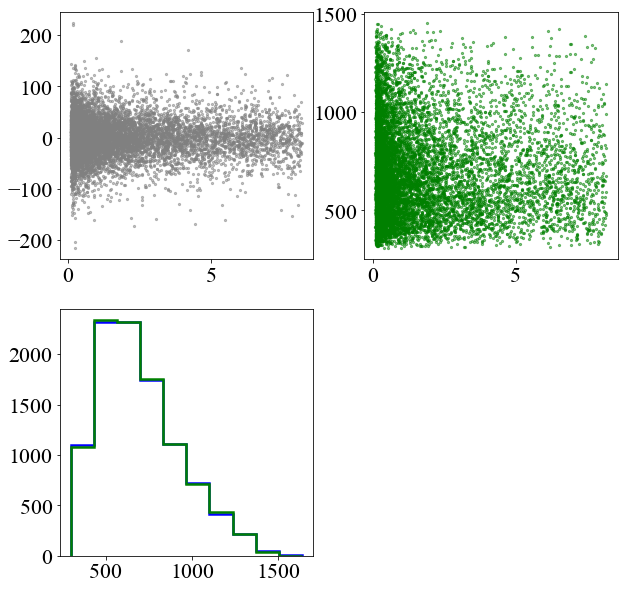

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].scatter(r_obs, Teff_obs-Teff, s=5, color="grey", alpha=0.5)
ax[0, 1].scatter(r_obs, Teff, s=5, color="green", alpha=0.5)

_, bins, _ = ax[1, 0].hist(Teff_obs, color="blue", histtype="step", linewidth=2.5)
_, _, _ = ax[1, 0].hist(Teff, bins=bins, color="green", histtype="step", linewidth=2.5)

ax[1, 1].remove()

In [6]:
Tobs = temperature_withDM(r_obs, heat_int, f=1, R=R_jup.value, 
                          M=mass*M_sun.value, parameters=[1, 20, 0.42])

Tobs_obs = Tobs + np.random.normal(loc=0, scale=(rel_unc*Tobs), size=N)

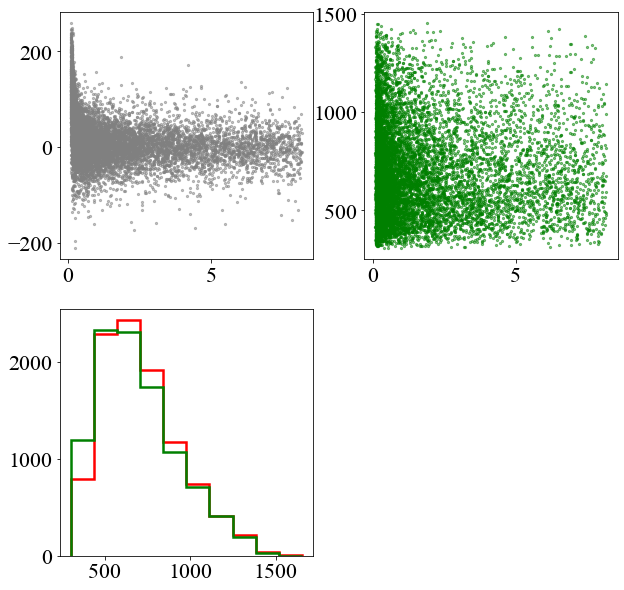

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

ax[0, 0].scatter(r_obs, Tobs_obs-Teff, s=5, color="grey", alpha=0.5)
ax[0, 1].scatter(r_obs, Teff, s=5, color="green", alpha=0.5)

_, bins, _ = ax[1, 0].hist(Tobs_obs, color="red", histtype="step", linewidth=2.5)
_, _, _ = ax[1, 0].hist(Teff, bins=bins, color="green", histtype="step", linewidth=2.5)

ax[1, 1].remove()

In [50]:
r_bins = np.logspace(np.log10(0.1), np.log10(8.178), 10)
mean_eff = []; mean_obs = []
std_eff = []; std_obs = []
_r = []

res_eff = Teff_obs - Teff
res_obs = Tobs_obs - Teff

for i in range(len(r_bins)-1):
    pos = np.where((r_obs > r_bins[i]) & (r_obs < r_bins[i+1]))
    #print(len(r_obs[pos]))
    mean_eff.append(np.mean(res_eff[pos])); std_eff.append(np.std(res_eff[pos]))
    mean_obs.append(np.mean(res_obs[pos])); std_obs.append(np.std(res_obs[pos]))
    _r.append(0.5*(r_bins[i] + r_bins[i+1]))

std_eff = np.array(std_eff)
std_obs = np.array(std_obs)

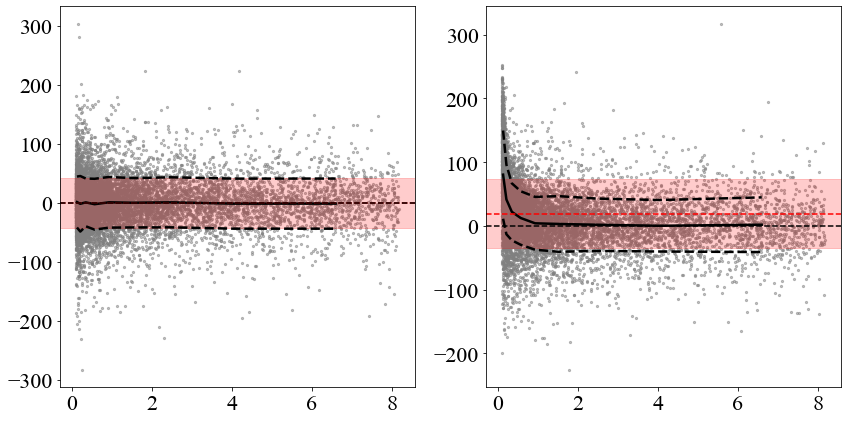

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))


ax[0].scatter(r_obs, Teff_obs-Teff, s=5, color="grey", alpha=0.5)
ax[0].plot(_r, mean_eff, color="k", lw=2.5)
ax[0].plot(_r, mean_eff + std_eff, color="k", lw=2.5, ls="--")
ax[0].plot(_r, mean_eff-std_eff, color="k", lw=2.5, ls="--")
ax[0].axhline(np.mean(res_eff), ls="--", color="r")
ax[0].axhspan(np.mean(res_eff)-np.std(res_eff), np.mean(res_eff)+np.std(res_eff), color="r", alpha=0.2)
ax[0].axhline(0, ls="--", color="k")

ax[1].scatter(r_obs, Tobs_obs-Teff, s=5, color="grey", alpha=0.5)
ax[1].plot(_r, mean_obs, color="k", lw=2.5)
ax[1].plot(_r, mean_obs+std_obs, color="k", lw=2.5, ls="--")
ax[1].plot(_r, mean_obs-std_obs, color="k", lw=2.5, ls="--")
ax[1].axhline(np.mean(res_obs), ls="--", color="r")
ax[1].axhspan(np.mean(res_obs)-np.std(res_obs), np.mean(res_obs)+np.std(res_obs), color="r", alpha=0.2)
ax[1].axhline(0, ls="--", color="k")

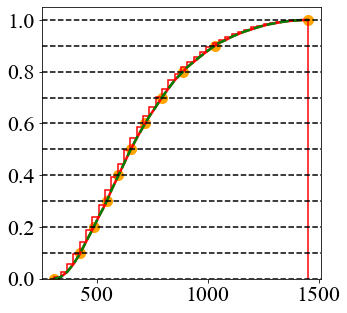

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

p, bins, _ = ax.hist(Teff, bins=40, density=True, histtype="step", linewidth=1.5, color="red", cumulative=True)
p = np.insert(p, 0, 0)
ax.plot(bins, p, color="red", lw=2.5)

p_interp = interp1d(bins, p)
ax.plot(bins, p_interp(bins), color="green", ls="--", lw=2.5)

def interp_find_x(x, y):
    return p_interp(x) - y

y_h = np.linspace(0, 1, 11)
bins_equal = []
for y in y_h:
    ax.axhline(y, ls="--", color="k")
    root = newton(interp_find_x, 400, args=(y, ))
    ax.scatter(root, y, s=100, color="orange")
    bins_equal.append(root)

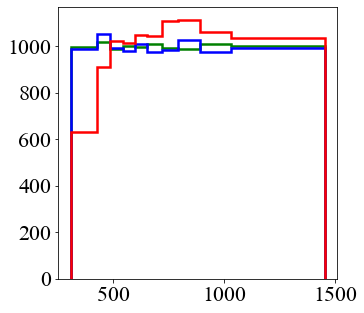

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

counts_th, _, _ = ax.hist(Teff, bins=bins_equal, histtype="step", linewidth=2.5, color="green")
counts_eff, _, _ = ax.hist(Teff_obs, bins=bins_equal, histtype="step", linewidth=2.5, color="blue")
counts_obs, _, _ = ax.hist(Tobs_obs, bins=bins_equal, histtype="step", linewidth=2.5, color="red")

In [123]:
def interp_find_x(x, y, p_interp):
    #print(x, y, p_interp(x), p_interp(x)-y)
    try:
        # return
        return p_interp(x) - y
    except:
        return np.inf

def sensitivity(Tobs, Teff, alpha=0.05):
    """
    Perform goodness-of-fit test and returns True/False if theretical cooling 
    models can/cannot explain observations
    """
    # Make number of counts histogram
    ## Calculate bins with equal probability

    p, bins, _ = ax[0, 0].hist(Teff, bins=40, density=True, cumulative=True, histtype="step", linewidth=1.5, color="red")
    p          = np.insert(p, 0, 0)
    p    = np.insert(p, len(p), 1)
    bins = np.insert(bins, len(bins), bins[len(bins)-1]+1000)
    x0   = bins[1]
    p    = np.insert(p, 0, 0)
    bins = np.insert(bins, 0, 0)

    p_interp   = interp1d(bins, p)
    y_h        = np.linspace(0.1, 0.9, 9) # total number of bins = 10
    bins_equal = []
    bins_equal.append(x0)
    for y in y_h:
        root = brentq(interp_find_x, x0, bins[-2], args=(y, p_interp))
        """
        try: 
            #print(y, newton(interp_find_x, x0, args=(y, )))
            root = newton(interp_find_x, x0, args=(y, p_interp,))
        except:
            if y == y_h[-1]:
                #print(y)
                root = bins[-2]
            else:
                x0 = x0 + 50
                #print("except", y, newton(interp_find_x, x0, args=(y, )))
                root = newton(interp_find_x, x0, args=(y, p_interp, ))
        """
        ax[0, 0].axhline(y, ls="--", color="k")
        ax[0, 0].scatter(root, y, s=100, color="orange")
        
        x0 = root
        bins_equal.append(root)
    bins_equal.append(bins[-2])
    ax[0, 0].scatter(bins[-2], 1., s=100, color="orange")
    try:
        # n_th = 0.10*nBDs (or similar)
        n_th, _ = np.histogram(Teff, bins=bins_equal) # theoretical counts
    except ValueError:
        print(bins_equal)
        sys.exit(-1)
    #print(n_th)
    n, _    = np.histogram(Tobs, bins=bins_equal)

    _chi2   = np.sum(np.power(n-n_th, 2)/n_th) # observed counts
    p_value = chi2.sf(_chi2, len(n)-1)
    #print(p_value)
    if p_value >= alpha:
        # return
        return 1, bins_equal
    else:
        # return
        return 0, bins_equal

====== nBDS=10000, rel_unc=0.05, f=0.1, gamma=0.2


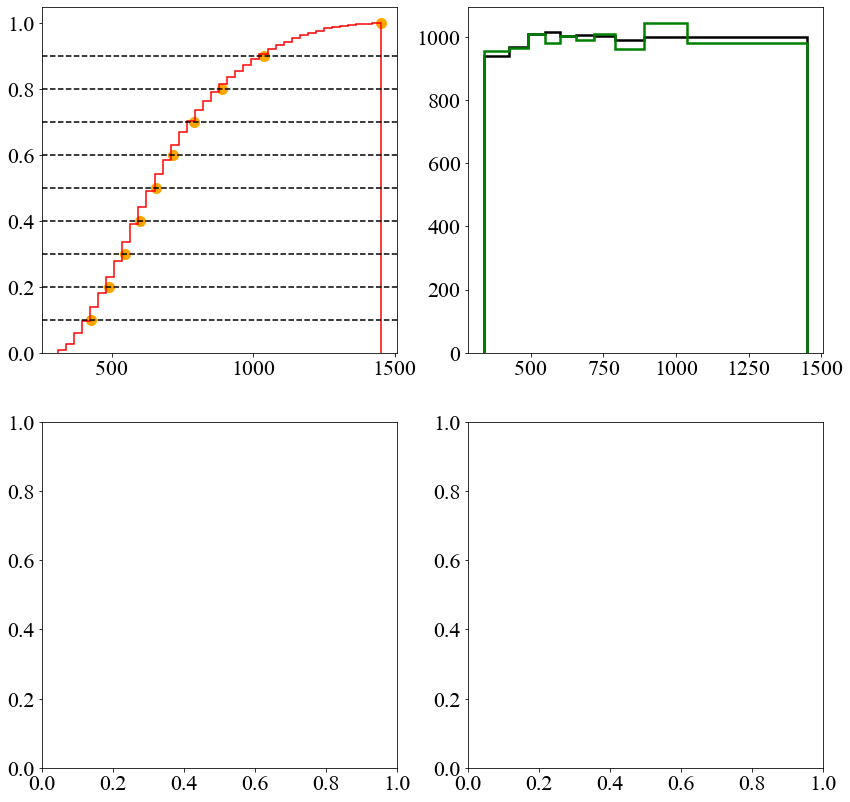

In [124]:
nBDs = 10000
rel_unc = 0.05
f     = [0.1]
gamma = [0.2]
rank  = 1
fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for _f in f:
    for _g in gamma:
        print("====== nBDS=%i, rel_unc=%.2f, f=%.1f, gamma=%.1f" 
                %(nBDs, rel_unc, _f, _g))
        _bool = np.ones(rank)*100
        for i in range(rank):
            _, Tobs, _, Teff, _, _ = mock_population(nBDs, rel_unc, 0., _f, _g)
            _bool[i], bins_equal = sensitivity(Tobs, Teff)
            if i==0 and _bool[i] == 1:
                counts_th, _, _ = ax[0, 1].hist(Teff, bins=bins_equal, histtype="step", linewidth=2.5, color="k")
                counts_obs, _, _ = ax[0, 1].hist(Tobs, bins=bins_equal, histtype="step", linewidth=2.5, color="green")
            if _bool[i]==0:
                counts_th, _, _ = ax[1, 1].hist(Teff, bins=bins_equal, histtype="step", linewidth=2.5, color="k")
                counts_obs, _, _ = ax[1, 1].hist(Tobs, bins=bins_equal, histtype="step", linewidth=2.5, color="green")
                break
        #print("Accepted H0 : %i" %int(np.sum(_bool)))
        #print("Rejected H0 : %i" %(len(_bool)-int(np.sum(_bool))))
   

# PLOTS

In [89]:
import utils_plots
imp.reload(utils_plots)
from utils_plots import sensitivity_grid

def plot_sensitivity_grid(filepath):
    fig, axes = plt.subplots(2, 3, figsize=(14, 10), sharex=True, sharey=True)
    
    _nBDs = [100, 1000, 10000]
    _rel_unc = [0.05, 0.1]
    nBDs    = []
    rel_unc = []

    for rel in _rel_unc:
        for n in _nBDs:
            nBDs.append(n)
            rel_unc.append(rel)
        
    for i, ax in enumerate(axes.flat):
        
        sensitivity_grid(filepath, nBDs[i], rel_unc[i], ax=ax)
        
        if i==0 or i==3:
            ax.set_ylabel(r"$\gamma$")
        if i >= 3:
            ax.set_xlabel(r"$f$")
        
        text_box = AnchoredText((r"N=%i, $\sigma_T$=%i" %(nBDs[i], int(rel_unc[i]*100)) + "$\%$"),
                                bbox_to_anchor=(0., 0.99),
                                bbox_transform=ax.transAxes, loc='lower left', pad=0.04, prop=dict(size=20))
        
        plt.setp(text_box.patch, facecolor="white")
        ax.add_artist(text_box)
        
        plt.yticks([0.2, 0.6, 1.0, 1.4, 1.8], ['0.2', '0.6', '1', '1.4', '1.8'])
        plt.xticks([0.1, 0.3, 0.5, 0.7, 0.9], ['0.1', '0.3', '0.5', '0.7', '0.9'])
    
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2.5)
    
    fig.subplots_adjust(wspace=0.08)
    fig.savefig("../Figs/ex1_sensitivity.pdf")

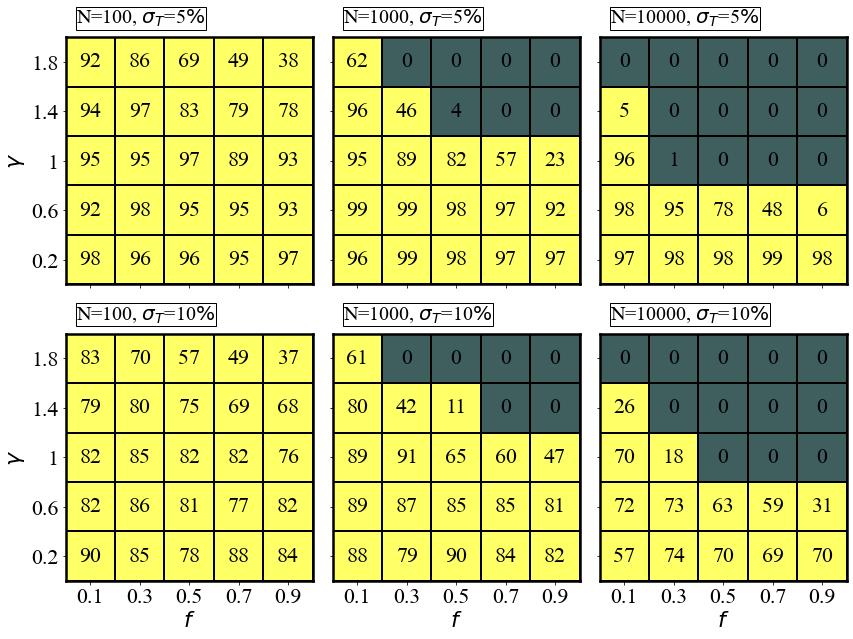

In [90]:
filepath = "/Users/mariabenito/Desktop/results/ex1/"
plot_sensitivity_grid(filepath)

In [74]:
import utils_plots
imp.reload(utils_plots)
from utils_plots import sensitivity_grid

def plot_sensitivity_grid(filepath):
    fig, axes = plt.subplots(2, 4, figsize=(19, 10), sharex=True, sharey=True)
    
    _nBDs    = [100, 10000]
    _rel_unc = [0.05, 0.1]
    _relM    = [0.10, 0.20]
    nBDs     = []
    rel_unc  = []
    relM     = []
    
    for n in _nBDs:
        for rel in _rel_unc:
            for rM in _relM:
                nBDs.append(n)
                rel_unc.append(rel)
                relM.append(rM)
        
    for i, ax in enumerate(axes.flat):
        
        sensitivity_grid(filepath, nBDs[i], rel_unc[i], relM[i], ax=ax)
        
        if i==0 or i==4:
            ax.set_ylabel(r"$\gamma$")
        if i >= 4:
            ax.set_xlabel(r"$f$")
        
        text_box = AnchoredText((r"N=%i, $\sigma_T$=%i" %(nBDs[i], int(rel_unc[i]*100)) + "$\%, $" 
                                + "$\sigma_M$=%i" %(int(relM[i]*100)) + "$\%$"),
                                bbox_to_anchor=(0., 0.99),
                                bbox_transform=ax.transAxes, loc='lower left', pad=0.04, prop=dict(size=20))
        
        plt.setp(text_box.patch, facecolor="white")
        ax.add_artist(text_box)
        
        plt.yticks([0.2, 0.6, 1.0, 1.4, 1.8], ['0.2', '0.6', '1', '1.4', '1.8'])
        plt.xticks([0.1, 0.3, 0.5, 0.7, 0.9], ['0.1', '0.3', '0.5', '0.7', '0.9'])
    
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2.5)
    
    fig.subplots_adjust(wspace=0.08)
    fig.savefig("../Figs/ex3_sensitivity.pdf")

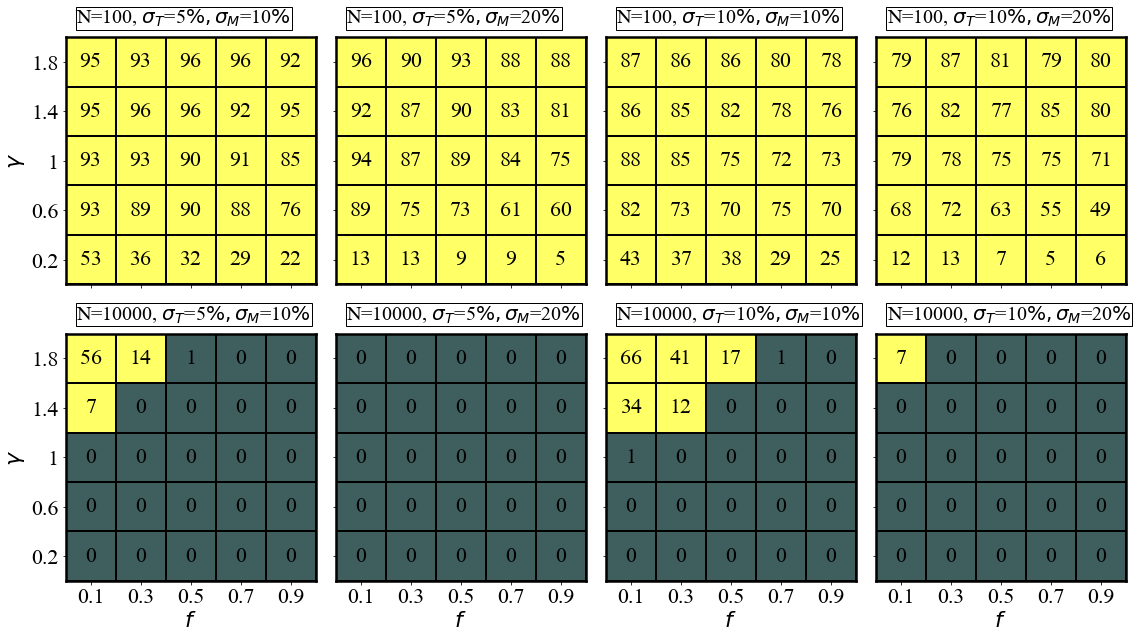

In [75]:
filepath = "/Users/mariabenito/Desktop/results/ex3/"
plot_sensitivity_grid(filepath)

In [5]:
import utils_plots
imp.reload(utils_plots)
from utils_plots import sensitivity_grid

def plot_sensitivity_grid(filepath, exercise):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
    
    _nBDs    = [100, 1000]
    _rel_unc = [0.1]
    _relM    = [0.10]
    nBDs     = []
    rel_unc  = []
    relM     = []
    
    for n in _nBDs:
        for rel in _rel_unc:
            for rM in _relM:
                nBDs.append(n)
                rel_unc.append(rel)
                relM.append(rM)
        
    for i, ax in enumerate(axes.flat):
        
        sensitivity_grid(filepath, nBDs[i], rel_unc[i], relM[i], ax=ax)
        
        if i==0:
            ax.set_ylabel(r"$\gamma$")
        ax.set_xlabel(r"$f$")
        
        text_box = AnchoredText((r"N=%i, $\sigma_T$=%i" %(nBDs[i], int(rel_unc[i]*100)) + "$\%, $" 
                                + "$\sigma_M$=%i" %(int(relM[i]*100)) + "$\%$"),
                                bbox_to_anchor=(0., 0.99),
                                bbox_transform=ax.transAxes, loc='lower left', pad=0.04, prop=dict(size=20))
        
        plt.setp(text_box.patch, facecolor="white")
        ax.add_artist(text_box)
        
        plt.yticks([0.2, 0.6, 1.0, 1.4, 1.8], ['0.2', '0.6', '1', '1.4', '1.8'])
        plt.xticks([0.1, 0.3, 0.5, 0.7, 0.9], ['0.1', '0.3', '0.5', '0.7', '0.9'])
    
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2.5)
    
    fig.subplots_adjust(wspace=0.08)
    fig.savefig("../Figs/" + exercise + "_sensitivity.pdf")

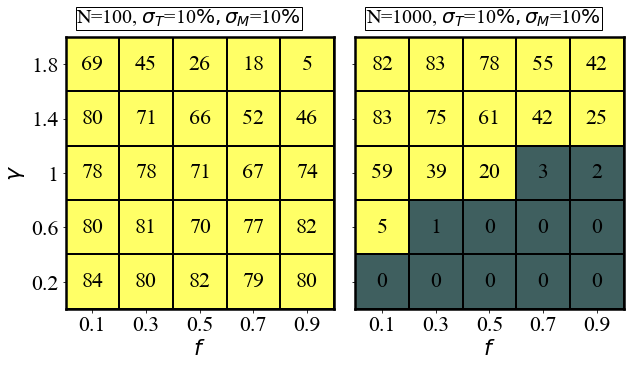

In [6]:
filepath = "/Users/mariabenito/Desktop/results/ex4/"
plot_sensitivity_grid(filepath, "ex4")